In [1]:
from processing.preprocess import save_spectrogram
from dotenv import load_dotenv
import os
import warnings
import torch
import numpy as np
from pytube import YouTube
from moviepy.editor import *

sys.path.insert(0, './model')
sys.path.insert(0, './processing')
from encoder_only_transformer import OnsetsFrames
from encoder_only_transformer import VelocityModel
from pred_to_midi import folder_to_midi
from pred_to_midi import create_frames_velocity_dict
warnings.filterwarnings('ignore')

In [43]:
class Prediction():
    # init
    def __init__(self, of_model, vel_model, of_path, vel_path, output_folder, device = 'cuda'):
        # Load in the model
        self.device = device
        self.of_model = of_model
        self.vel_model = vel_model
        self.of_path = of_path
        self.vel_path = vel_path

        self.of_model.load_state_dict(torch.load(self.of_path, map_location=torch.device(device)), strict=False)
        self.vel_model.load_state_dict(torch.load(self.vel_path, map_location=torch.device(device)), strict=False)

        # Set up directories
        self.output_folder = output_folder

    def intersect_frames_onsets(self, frames, onsets):
        ''' 
            Modify the frames array such that it only contains notes 
            if it contains an onset
        '''
        frames_new = np.zeros(frames.shape)

        
        for i in range(len(frames)):
            # Go through every note:
            record_current = False

            for j in range(len(frames[0])):
                
                is_played = (frames[i][j] == 1)
                is_true_onset = (onsets[i][j] == 1)
                if j == 0: is_onset = is_played
                else: is_onset = is_played and frames[i][j-1] == 0
                
                if is_played:
                    
                    if is_true_onset:
                        frames_new[i][j] = 1
                        j_last = j # Reset the onset time
                        record_current = True

                    else:
                        if record_current:
                            frames_new[i][j] = 1
                        else:
                            continue

                else:
                    record_current = False

        return frames_new

    def prepare(self, input_file, song_name):
        '''
        Generates the 20s spectrograms of the given input .wav file,
        and outputs it in the output_folder in:
            output_folder/output_name/raw/
        '''
        output_dir = os.path.join(self.output_folder, song_name)
        save_spectrogram(input_file, output_dir, "raw____") # extra characters are a workaround for a poorly implemented save_spectrogram function

    def prepare_for_model(self, data):
        '''
        Turns a numpy array into a tensor
        '''
        data = torch.from_numpy(data)
        data = data.unsqueeze(0)
        data = data.transpose(1,2)
        return data

    def prepare_after_model(self, data, tolerance = 0):
        '''
        Turns a tensor into a numpy array and normalizes logits to 0 and 1
        '''
        data = data.squeeze(0)
        data = data.transpose(0,1)
        data = data.detach().numpy()
        for i in range(len(data)):
            for j in range(len(data[i])):
                if data[i][j] > tolerance:
                    data[i][j] = 1
                else:
                    data[i][j] = 0
        return data

    def run_model(self, song_name):
        '''
        Runs the model on every numpy file in the folder
            
            output_folder/song_name/raw/

        and outputs the predictions in

            output_folder/song_name/frames
            output_folder/song_name/onsets
            output_folder/song_name/velocities

        model_type can be:
            "onsets"
            "frames"
            "offsets"
            "velocities"
        '''

        # Create the folder if not already created
        output_dir_frames = os.path.join(self.output_folder, song_name, "frames")
        if not os.path.isdir(output_dir_frames):
            os.makedirs(output_dir_frames)

        output_dir_onsets = os.path.join(self.output_folder, song_name, "onsets")
        if not os.path.isdir(output_dir_onsets):
            os.makedirs(output_dir_onsets)

        output_dir_velocities = os.path.join(self.output_folder, song_name, "velocities")
        if not os.path.isdir(output_dir_velocities):
            os.makedirs(output_dir_velocities)

        # Load in the dataset
        raw_path = os.path.join(self.output_folder, song_name, "raw")
        spectrogram_list = os.listdir(raw_path)
        spectrogram_list = sorted(spectrogram_list, key=lambda x: float(x.split('_')[1].split('.')[0]))

        # Iterate through everything in the loader
        for spec in spectrogram_list:
            if spec.endswith("20.npy"):
                # Load data and turn into right shape
                data = self.prepare_for_model(np.load(os.path.join(raw_path, spec)))
                # Prediction
                onsets, frames = self.of_model(data)
                velocities = self.vel_model(data)

                onsets = self.prepare_after_model(onsets, tolerance = - 3)
                frames = self.prepare_after_model(frames)

                frames = self.intersect_frames_onsets(frames, onsets)
                velocities = velocities.squeeze(0)
                velocities = velocities.transpose(0,1)
                velocities = velocities.detach().numpy()
                velocities = velocities * onsets
                
                # Save the output
                np.save(os.path.join(output_dir_frames, spec), frames)
                np.save(os.path.join(output_dir_onsets, spec), onsets)
                np.save(os.path.join(output_dir_velocities, spec), velocities)

    def wav_to_wav(self, input_file, song_name):
        self.prepare(input_file, song_name)

        self.run_model(song_name)

        frames_folder = os.path.join(self.output_folder, song_name, "frames")
        velocity_folder = os.path.join(self.output_folder, song_name, "velocities")
        folder_to_midi(frames_folder, velocity_folder, os.path.join(self.output_folder,song_name,song_name+"_synthesized.midi"))
        

    def pred_youtube_to_wav(self, youtube_url, song_name):
        '''
        Downloads the youtube video and converts it to a .wav file.
        Then makes a prediction on the .wav file.

        Credit for Downloading Code: https://stackoverflow.com/questions/27473526/download-only-audio-from-youtube-video-using-youtube-dl-in-python-script
        ''' 
        # Download the video as .wav and save it
        yt = YouTube(youtube_url)
        video = yt.streams.filter(only_audio=True).first()
        out_file = video.download(output_path=".")

        # Make directory if doesn't exist
        output_dir = os.path.join(self.output_folder, song_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        new_file = os.path.join(output_dir, song_name+".wav")
        os.rename(out_file, new_file)

        # Make predictions
        self.wav_to_wav(new_file, song_name)
    
    def pred_mp4_to_wav(self, input_mp4, song_name, start="00:00:00", end=-1):
        '''
        Converts a mp4 file to a wav file.
        Then makes a prediction on the .wav file

        Defaults to starting at t='00:00:00' and ending at t=MAX
        where time is in 'hh:mm:ss' format
        '''

        # # Convert mp4 to wav
        wav_file = os.path.join(self.output_folder, song_name, song_name+".wav")
        output_dir = os.path.join(self.output_folder, song_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)

        videoclip = VideoFileClip(input_mp4)
        
        if end == -1:
            end = videoclip.duration

        videoclip = videoclip.subclip(start, end)
        audioclip = videoclip.audio
        audioclip.write_audiofile(wav_file)
        # Trim the audioclip


        audioclip.close()
        videoclip.close()

        # return
        self.wav_to_wav(wav_file, song_name)

In [44]:
device = 'cpu'
of_model = OnsetsFrames(229, 512, 16, 512, 8, bias2=True, dropout=0.1)
vel_model = VelocityModel(229, 512, 16, 512, 8)
of_path = 'fr_2.pt'
vel_path = 'vel.pt'
output_folder = os.environ.get('testname')

# Create a Prediction class
chopin = Prediction(of_model, vel_model, of_path, vel_path, output_folder, device)

In [42]:
chopin.pred_youtube_to_wav("https://www.youtube.com/watch?v=GmK9zg4-fuE", "clean")

In [45]:
chopin.pred_mp4_to_wav("demo2.mp4", "demo3")


chunk:  16%|█▌        | 319/2049 [00:00<00:00, 3187.50it/s, now=None]

MoviePy - Writing audio in test_data/demo3/demo3.wav


MoviePy - Done.


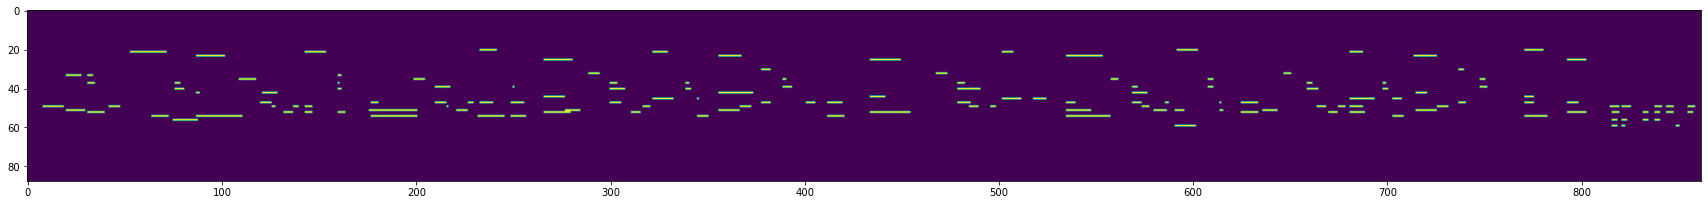

In [31]:
a = np.load("test_data/rickroll2/frames/offset_40.0_duration_20.npy")
plt.figure(figsize=(30,10))
plt.imshow(a)

In [12]:
import matplotlib.pyplot as plt